# Sim4FSJ Example


## example/example.yaml
```
input_file: 'example.fjs'
job_concurrency: 0.01
job_duedate_factor: 1.1
```

## example/example.fjs
```
2   3
1   1   1   2
2   2   1   3   2   5   1   3   4
```

## Creating an instance

In [1]:
import sys
sys.path.append("..")

import sim4fjs.instance
instance = sim4fjs.instance.Instance.from_file("example.yaml")

print(instance.to_string())

# Note that the start of the second job is 1, not 0.
# This is because job_concurrency is > 0 in example.yaml.

Jobs
Job 0 start=0, due=3
  Operation 0:
    machine=  1,duration=  2
Job 1 start=1, due=9
  Operation 0:
    machine=  1,duration=  3
    machine=  2,duration=  5
  Operation 1:
    machine=  3,duration=  4



## Visualizing the jobs of an instance
The following chart shows the two jobs in a Gantt diagram.

The second job starts not immediately because job concurrency is > 0.

The light grey area indicates slack time (the due date being later than the shortest possible run time, i.e. when always the shortest mode of an operation is chosen by the simulation). For instance, for the second job, the shortest possible duration is 7, because the shortest operation modes are 3 and 4 time units long. The duration including slack time is 7*1.1, since the job due date factor is 1.1, which is rounded up to 8.

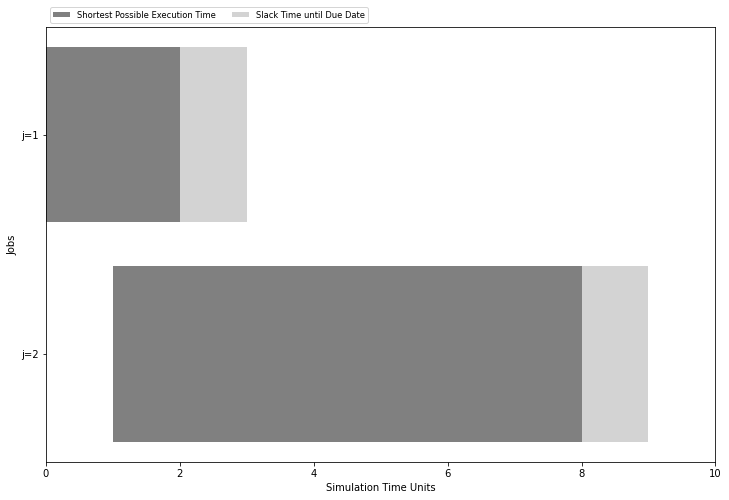

In [2]:
import sim4fjs.visualization
fig =  sim4fjs.visualization.instance_gantt(instance)

## Visualizing the modes of an instance
In this chart q indicates the mode, j the job.

The first job has only one operation with one mode but the diagram shows two rows for j=1. Each job will always have a fixed number of rows - the overall maximum of the number of modes per operation.

The second job has two operations. The first operation has two modes (q=1 and q=2).

The start of an operation is visualized at the point in time when the longest mode of the previous operation has finished. This is for better overview in the diagram. Note that in a simulation, the operation could start earlier, if the simulation selected a shorter mode for the previous operation, i.e. as soon as the previous operation has finished.

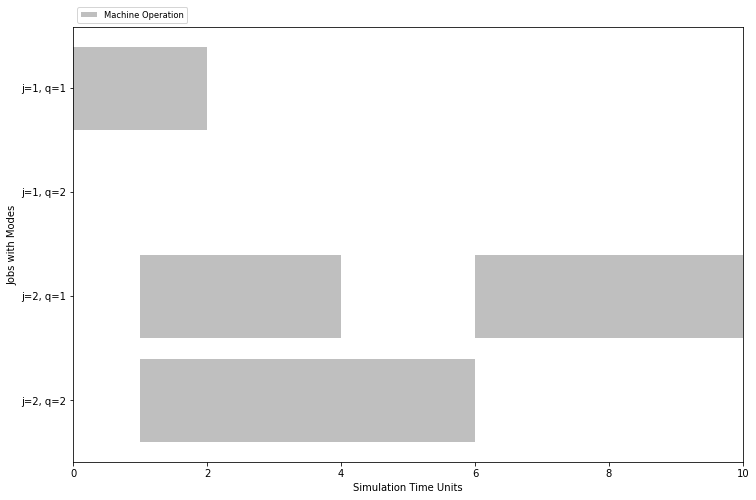

In [3]:
fig =  sim4fjs.visualization.machine_modes_gantt(instance)

## Visualizing a simulation run
This Gantt chart shows the actual operation modes chosen and carried out by the simulation according to the priority rules.

The first job has only one operation - which was carried out immediately.

The second job started at time=1 since that is its start date. The simulation selected the second mode of the first operation (duration 5) because it uses machine 2 which is still free. The second operation of the second job starts immediately after the first and takes 4 time units.

Note that this is not the optimal solution, since Sim4FJS just simulates according to the mentioned priority rules but does no optimization.

The overall duration would have been 1 time unit shorter if the first mode of the second job had been selected. It would have had to wait for 1 time unit but would have finished within 3 time units instead of 5 like the second mode.

In [4]:
import sim4fjs.simulation
run = sim4fjs.simulation.Simulation(instance).run()

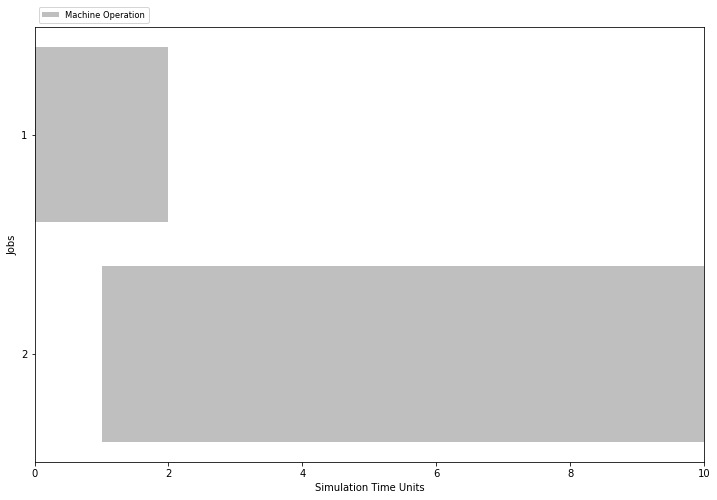

In [5]:
fig = sim4fjs.visualization.machine_simulation_run_gantt(run)

## Exporting a simulation run data as csv
The csv shows one operation per line and (for better overview) also shows all modes of an operation in square brackets.

The columns represent simulation times at which a machine starts or stops operating.

The numbers in the cells are the machine ids of the machines in operation at that time.

In [6]:
# output and show the simulation result csv
# the column headers represent simulation time
# the numbers to the right of the operations indicate the machine number that was used by the operation
with open("example_output.csv", 'w') as f:
    for line in run.csv_representation():
        f.write(line)
        f.write('\n')
        print(line)

;;0;1;2;6;10
Op 0 0;[(1, 2)];1;1;1;;
Op 1 0;[(1, 3), (2, 5)];;2;2;2;
Op 1 1;[(3, 4)];;;;3;3


|      |                |0  |1  |2  |6  |10 |
|------|----------------|---|---|---|---|---|
|Op 0 0|[(1, 2)]        |1  |1  |1  |   |   |
|Op 1 0|[(1, 3), (2, 5)]|   |2  |2  |2  |   |
|Op 1 1|[(3, 4)]        |   |   |   |3  |3  |

Note that a situation in a csv like

|1|3|5|
|-|-|-|
|5|5| |
| |5|5|

would *not* indicate two overlapping operations on machine 5 (which would not be allowed).

Rather, the two operations both have duration 2, the first starts at 1 and ends at 3, the second starts at 3 and ends at 5, such that there is no overlap.